# 流程：
1.将细胞图分类：阴性、阳性
2.分别读取文件夹中的阴性、阳性细胞图，然后处理：LBP处理、LBP对应的直方图(这里怎么处理??)、归一化得到直方图特征向量
3.svm 训练

In [1]:
import numpy as np
import cv2
from skimage import feature as skft
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from time import time
import datetime
from os import listdir
import matplotlib.pyplot as plt

getLBPandHistogram()生成的直方图向量维度是（1，256），样本数量总共才261，太不合理，需要做改进

In [2]:
def getLBPandHistogram(filename,method='default'):
    img = cv2.imread(filename,0)
    lbp = skft.local_binary_pattern(img,8,1,method=method)
    max_bins = 256
    hist,_ = np.histogram(lbp,range=(0,max_bins),bins=max_bins)
    hist = hist/hist.max()
    return hist.tolist()

def loadImageData():
    positiveImgFile = listdir(r'D:\36451\learningfile\LBPClassification\positive')
    negativeImgFile = listdir(r'D:\36451\learningfile\LBPClassification\negative')

    positiveDir = 'D:/36451/learningfile/LBPClassification/positive/'
    negativeDir = 'D:/36451/learningfile/LBPClassification/negative/'
    
    pathDir = []
    dataMat = []
    labels = []

    m = len(positiveImgFile)
    n = len(negativeImgFile)

    for i in range(m):
        fileNameStr = positiveImgFile[i]
        filename = positiveDir+fileNameStr
        pathDir.append(filename)
        dataMat.append(getLBPandHistogram(filename))
        labels.append(1)

    for j in range(n):
        fileNameStr = negativeImgFile[j]
        filename = negativeDir+fileNameStr
        pathDir.append(filename)
        dataMat.append(getLBPandHistogram(filename))
        labels.append(0)
        
    return np.array(dataMat),np.array(labels),pathDir

def trainSet_testSet_split(dataSet,labelSet,test_size=0.3):
    m = labelSet.sum()
    n = len(labelSet) - m
    
    lenOfPositiveTestSet = int(m*test_size)
    lenOfNegativeTestSet = int(n*test_size)
    
    trainSet = []
    trainLabels = []
    testSet = []
    testLabels = []
    testSet_index = []#测试集的索引列表
    
    for i in range(lenOfPositiveTestSet):
        randIndex = np.random.random_integers(0,m-1)
        while randIndex in testSet_index:
            randIndex = np.random.random_integers(m)
        testSet_index.append(randIndex)
        testSet.append(dataSet[randIndex])
        testLabels.append(labelSet[randIndex])
    for j in range(lenOfNegativeTestSet):
        randIndex = np.random.random_integers(m,len(labelSet)-1)
        while randIndex in testSet_index:
            randIndex = np.random.random_integers(m,len(labelSet)-1)
        testSet_index.append(randIndex)
        testSet.append(dataSet[randIndex])
        testLabels.append(labelSet[randIndex])
    
    totalIndex = list(range(len(labelSet)))
    indexs = [index for index in totalIndex if not index in testSet_index]
    for index in indexs:
        trainSet.append(dataSet[index])
        trainLabels.append(labelSet[index])
    return np.array(trainSet),np.array(testSet),np.array(trainLabels),np.array(testLabels),testSet_index

def differentKernelOfSvmTraining():
    data,target,pathDir = loadImageData()
    #X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.3,random_state=42)
    X_train,X_test,Y_train,Y_test,testSet_index = trainSet_testSet_split(data,target)
    kernel = ['linear','poly','rbf','sigmoid']
    predictResult = []
    for k in kernel:
        time0 = time()
        clf = SVC(kernel = k
                  , gamma = 'auto'
                  , degree = 1
                  , cache_size = 5000#MB,分给运行此代码的内存
                 ).fit(X_train,Y_train)
        print('the accuracy under kernel %s is %f'%(k,clf.score(X_test,Y_test)))
        print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f'))
        predictResult.append(clf.predict(X_test))
    return predictResult,Y_test,pathDir,testSet_index

In [3]:
predictResult,realResult,pathDir,testSet_index = differentKernelOfSvmTraining()

the accuracy under kernel linear is 0.871795
00:00:009992
the accuracy under kernel poly is 0.628205
00:00:009999
the accuracy under kernel rbf is 0.628205
00:00:009995
the accuracy under kernel sigmoid is 0.628205
00:00:009995


C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 96 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: This function is deprecated. Please call randint(1, 97 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: This function is deprecated. Please call randint(97, 260 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: This function is deprecated. Please call randint(97, 260 + 1) instead


In [4]:
def pathOfFailInPredict(predictResult,realResult,pathDir,testSet_index):
    assert len(predictResult) == len(realResult),"predictResult and realResult should be one-to-one!"
    
    fromPositiveToNegative = []
    fromNegativeToPositive = []
    pathOfWrongPredict = []
    
    count = 0
    for i in range(len(realResult)):
        if predictResult[i] != realResult[i]:
            count += 1
            if realResult[i] == 1:
                fromPositiveToNegative.append(pathDir[testSet_index[i]])
            else:
                fromNegativeToPositive.append(pathDir[testSet_index[i]])
    pathOfWrongPredict.append([fromPositiveToNegative,fromNegativeToPositive])
    accuracy = 1-count/len(realResult)
    print("accuracy:%f"%accuracy)
    
    return pathOfWrongPredict

In [5]:
path = pathOfFailInPredict(predictResult[0],realResult,pathDir,testSet_index)

accuracy:0.871795


In [6]:
path

[[['D:/36451/learningfile/LBPClassification/positive/1506591_18_LSIL.png',
   'D:/36451/learningfile/LBPClassification/positive/1506591_23_LSIL.png',
   'D:/36451/learningfile/LBPClassification/positive/15064210920157_2_ASCUS.png',
   'D:/36451/learningfile/LBPClassification/positive/Ta1506675_7_Ascus.png',
   'D:/36451/learningfile/LBPClassification/positive/1506591_8_Ascus.png',
   'D:/36451/learningfile/LBPClassification/positive/Ta1506675_9_Ascus.png'],
  ['D:/36451/learningfile/LBPClassification/negative/Ta17101254_34_negative.png',
   'D:/36451/learningfile/LBPClassification/negative/Ta1710267_34_negative.png',
   'D:/36451/learningfile/LBPClassification/negative/Ta17101254_47_negative.png',
   'D:/36451/learningfile/LBPClassification/negative/Ta17101254_56_negative.png']]]

以下是经过对所有图像进行resize成为统一大小的图片，然后进行统一的分割成为3*3，即9等份之后进行uniform_LBP，然后对得到的每个1/9直方图向量拼接起来形成一个1 * 90的直方图向量，最后进行SVM训练，效果也不理想

In [2]:
def imageResize(img,newSize=(324,324),interpolation=cv2.INTER_LINEAR):
    img = cv2.resize(img,dsize=newSize,interpolation=interpolation)
    return img
def getLBPFromImage(img,n_points=8,radius=1,method='uniform'):
    return skft.local_binary_pattern(img,P=n_points,R=radius,method=method)

def getHistogramVectorFromLBP(filename,height=324,width=324,method='uniform'):
    img = cv2.imread(filename,0)
    img = imageResize(img,newSize=(height,width))
    
    rows = height//3
    columns = width//3
    vector = np.array([])
    for i in range(3):
        for j in range(3):
            lbp = getLBPFromImage(img[rows*(i):rows*(i+1)-1, columns*(j):columns*(j+1)-1],method=method)
            hist,_ = np.histogram(lbp)
            vector = np.append(vector,hist/hist.max())  
    return vector

def loadImageData(method='uniform'):
    positiveImgFile = listdir(r'D:\36451\learningfile\LBPClassification\positive')
    negativeImgFile = listdir(r'D:\36451\learningfile\LBPClassification\negative')

    positiveDir = 'D:/36451/learningfile/LBPClassification/positive/'
    negativeDir = 'D:/36451/learningfile/LBPClassification/negative/'
    
    pathDir = []
    dataMat = np.array([])
    labels = []

    m = len(positiveImgFile)
    n = len(negativeImgFile)
    
    fileNameStr = positiveImgFile[0]
    filename = positiveDir+fileNameStr
    dataMat = getHistogramVectorFromLBP(filename,method=method)
    labels.append(1)
    for i in range(1,m):
        fileNameStr = positiveImgFile[i]
        filename = positiveDir+fileNameStr
        pathDir.append(filename)
        vector = (getHistogramVectorFromLBP(filename))
        dataMat = np.vstack((dataMat,vector))
        labels.append(1)

    for j in range(n):
        fileNameStr = negativeImgFile[j]
        filename = negativeDir+fileNameStr
        pathDir.append(filename)
        vector = (getHistogramVectorFromLBP(filename))
        dataMat = np.vstack((dataMat,vector))
        labels.append(0)
        
    return dataMat,np.array(labels),pathDir

def trainSet_testSet_split(dataSet,labelSet,test_size=0.3):
    m = labelSet.sum()
    n = len(labelSet) - m
    
    lenOfPositiveTestSet = int(m*test_size)
    lenOfNegativeTestSet = int(n*test_size)
    
    trainSet = []
    trainLabels = []
    testSet = []
    testLabels = []
    testSet_index = []#测试集的索引列表
    
    for i in range(lenOfPositiveTestSet):
        randIndex = np.random.random_integers(0,m-1)
        while randIndex in testSet_index:
            randIndex = np.random.random_integers(m)
        testSet_index.append(randIndex)
        testSet.append(dataSet[randIndex])
        testLabels.append(labelSet[randIndex])
    for j in range(lenOfNegativeTestSet):
        randIndex = np.random.random_integers(m,len(labelSet)-1)
        while randIndex in testSet_index:
            randIndex = np.random.random_integers(m,len(labelSet)-1)
        testSet_index.append(randIndex)
        testSet.append(dataSet[randIndex])
        testLabels.append(labelSet[randIndex])
    
    totalIndex = list(range(len(labelSet)))
    indexs = [index for index in totalIndex if not index in testSet_index]
    for index in indexs:
        trainSet.append(dataSet[index])
        trainLabels.append(labelSet[index])
    return np.array(trainSet),np.array(testSet),np.array(trainLabels),np.array(testLabels),testSet_index

def differentKernelOfSvmTraining():
    data,target,pathDir = loadImageData()
    #X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.3,random_state=100)
    X_train,X_test,Y_train,Y_test,testSet_index = trainSet_testSet_split(data,target)
    predictResult = []
    kernel = ['linear','poly','rbf','sigmoid']
    for k in kernel:
        time0 = time()
        clf = SVC(kernel = k
                  , gamma = 'auto'
                  , degree = 1
                  , cache_size = 5000#MB,分给运行此代码的内存
                 ).fit(X_train,Y_train)
        print('the accuracy under kernel %s is %f'%(k,clf.score(X_test,Y_test)))
        print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f'))
        predictResult.append(clf.predict(X_test))
    return predictResult,Y_test,pathDir,testSet_index

In [3]:
predictResult,realResult,pathDir,testSet_index =  differentKernelOfSvmTraining()

the accuracy under kernel linear is 0.884615
00:00:009994
the accuracy under kernel poly is 0.628205
00:00:000000
the accuracy under kernel rbf is 0.653846
00:00:009995
the accuracy under kernel sigmoid is 0.628205
00:00:000000


C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: This function is deprecated. Please call randint(0, 96 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: This function is deprecated. Please call randint(1, 97 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: This function is deprecated. Please call randint(97, 260 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: This function is deprecated. Please call randint(97, 260 + 1) instead


In [4]:
def pathOfFailInPredict(predictResult,realResult,pathDir,testSet_index):
    assert len(predictResult) == len(realResult),"predictResult and realResult should be one-to-one!"
    
    fromPositiveToNegative = []
    fromNegativeToPositive = []
    pathOfWrongPredict = []
    
    count = 0
    for i in range(len(realResult)):
        if predictResult[i] != realResult[i]:
            count += 1
            if realResult[i] == 1:
                fromPositiveToNegative.append(pathDir[testSet_index[i]])
            else:
                fromNegativeToPositive.append(pathDir[testSet_index[i]])
    pathOfWrongPredict.append([fromPositiveToNegative,fromNegativeToPositive])
    accuracy = 1-count/len(realResult)
    print("accuracy:%f"%accuracy)
    
    return pathOfWrongPredict

In [5]:
path = pathOfFailInPredict(predictResult[0],realResult,pathDir,testSet_index)

accuracy:0.884615


In [6]:
path

[[['D:/36451/learningfile/LBPClassification/positive/Ta1508145_3_ASCUS.png',
   'D:/36451/learningfile/LBPClassification/positive/Ta1506675_3_Ascus.png',
   'D:/36451/learningfile/LBPClassification/positive/15063560920130_1_ASCUS.png',
   'D:/36451/learningfile/LBPClassification/positive/1506591_10_LSIL.png',
   'D:/36451/learningfile/LBPClassification/positive/Ta1506222_1_Ascus.png',
   'D:/36451/learningfile/LBPClassification/positive/15063480920083_1_ASCUS.png'],
  ['D:/36451/learningfile/LBPClassification/negative/Ta17101254_42_negative.png',
   'D:/36451/learningfile/LBPClassification/negative/Ta17101254_44_negative.png',
   'D:/36451/learningfile/LBPClassification/negative/Ta1710267_9_negative.png']]]

In [1]:
import cv2
import matplotlib.pyplot as plt

(-0.5, 193.5, 136.5, -0.5)

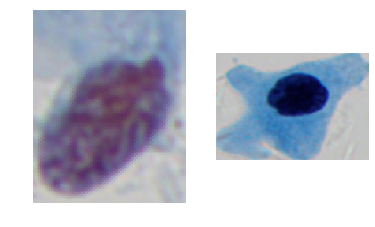

In [5]:
filename = 'D:/36451/learningfile/LBPClassification/positive/Ta1508145_3_ASCUS.png'
fn2 = 'D:/36451/learningfile/LBPClassification/positive/1506591_1_LSIL.png'

img1 = cv2.imread(filename)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = cv2.imread(fn2)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(img)
plt.axis('off')

plt.subplot(122)
plt.imshow(img2)
plt.axis('off')

(-0.5, 85.5, 108.5, -0.5)

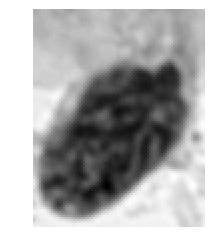

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

plt.imshow(gray,cmap=plt.cm.gray)
plt.axis('off')

In [9]:
import numpy as np

In [94]:
def trainSet_testSet_split(dataSet,labelSet,test_size=0.3):
    m = labelSet.sum()
    n = len(labelSet) - m
    
    lenOfPositiveTestSet = int(m*test_size)
    lenOfNegativeTestSet = int(n*test_size)
    
    trainSet = []
    trainLabels = []
    testSet = []
    testLabels = []
    testSet_index = []
    
    for i in range(lenOfPositiveTestSet):
        randIndex = np.random.random_integers(0,m-1)
        while randIndex in testSet_index:
            randIndex = np.random.random_integers(m)
        testSet_index.append(randIndex)
        testSet.append(dataSet[randIndex])
        testLabels.append(labelSet[randIndex])
    for j in range(lenOfNegativeTestSet):
        randIndex = np.random.random_integers(m,len(labelSet)-1)
        while randIndex in testSet_index:
            randIndex = np.random.random_integers(m,len(labelSet)-1)
        testSet_index.append(randIndex)
        testSet.append(dataSet[randIndex])
        testLabels.append(labelSet[randIndex])
    
    totalIndex = list(range(len(labelSet)))
    indexs = [index for index in totalIndex if not index in testSet_index]
    for index in indexs:
        trainSet.append(dataSet[index])
        trainLabels.append(labelSet[index])
    return trainSet,trainLabels,testSet,testLabels,testSet_index

In [59]:
x = np.random.random_integers(0,4)
x

C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 4 + 1) instead
  """Entry point for launching an IPython kernel.


3

In [95]:
data,labels = loadImageData()

In [96]:
X_train,Y_train,X_test,Y_test = trainSet_testTrain_split(data,labels)

C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 96 + 1) instead
  from ipykernel import kernelapp as app
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. Please call randint(1, 97 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: This function is deprecated. Please call randint(97, 260 + 1) instead
C:\Users\36451\Anaconda3\envs\python_3.5\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: This function is deprecated. Please call randint(97, 260 + 1) instead


In [100]:
Y_test

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [75]:
sorted(testIndex)

[2,
 3,
 4,
 19,
 22,
 23,
 26,
 34,
 35,
 37,
 43,
 46,
 53,
 56,
 57,
 61,
 63,
 64,
 66,
 70,
 71,
 75,
 78,
 79,
 80,
 82,
 89,
 90,
 96,
 97,
 98,
 99,
 100,
 102,
 113,
 116,
 118,
 121,
 124,
 126,
 137,
 140,
 142,
 147,
 159,
 161,
 163,
 174,
 177,
 181,
 189,
 195,
 196,
 197,
 198,
 201,
 202,
 203,
 204,
 212,
 213,
 215,
 216,
 217,
 224,
 227,
 233,
 238,
 240,
 241,
 243,
 245,
 246,
 247,
 250,
 257,
 259,
 260]

In [88]:
a = list(range(10))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [91]:
L1 = [1,2,3,4,5,6,7,8,9]
L2 = [3,4,5]

In [92]:
items = [item for item in L1 if not item in L2]

In [93]:
items

[1, 2, 6, 7, 8, 9]

In [70]:
tt = set(testIndex)

In [72]:
len(tt)

78

In [59]:
X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.3,random_state=420)

In [60]:
kernel = ['linear','poly','rbf','sigmoid']
for k in kernel:
    time0 = time()
    clf = SVC(kernel = k
              , gamma = 'auto'
              , degree = 1
              , cache_size = 5000#MB,分给运行此代码的内存
             ).fit(X_train,Y_train)
    print('the accuracy under kernel %s is %f'%(k,clf.score(X_test,Y_test)))
    print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f'))

the accuracy under kernel linear is 0.848101
00:00:006990
the accuracy under kernel poly is 0.658228
00:00:003955
the accuracy under kernel rbf is 0.708861
00:00:004022
the accuracy under kernel sigmoid is 0.658228
00:00:004984


(-0.5, 787.5, 425.5, -0.5)

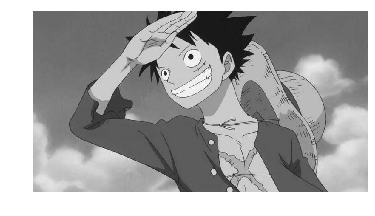

In [34]:
filename = 'C:/Users/36451/Desktop/lufei.jpg'
filename1 = 'C:/Users/36451/Desktop/1130.png'

img = cv2.imread(filename,0)
plt.imshow(img,cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 787.5, 425.5, -0.5)

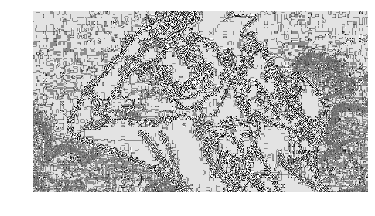

In [35]:
lbp = skft.local_binary_pattern(img,8,1,method='uniform')

plt.imshow(lbp,cmap=plt.cm.gray)
plt.axis('off')

In [36]:
lbp

array([[3., 5., 5., ..., 5., 5., 3.],
       [5., 8., 8., ..., 8., 8., 5.],
       [5., 8., 8., ..., 8., 8., 5.],
       ...,
       [1., 5., 5., ..., 6., 5., 3.],
       [9., 3., 4., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [37]:
np.unique(lbp)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [7]:
import numpy as np
import cv2
from skimage import feature as skft
import matplotlib.pyplot as plt

# filename = 'C:/Users/36451/Desktop/_00_244.png'
filename = 'C:/Users/36451/Desktop/001.png'
img = cv2.imread(filename,0)
img = cv2.resize(img,dsize=(324,324),interpolation=cv2.INTER_LINEAR)

(-0.5, 323.5, 323.5, -0.5)

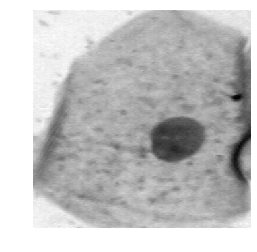

In [8]:
plt.imshow(img,cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 323.5, 323.5, -0.5)

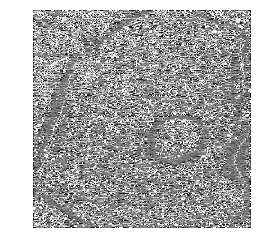

In [9]:
lbp = skft.local_binary_pattern(img,8,1,method='uniform')

plt.imshow(lbp,cmap=plt.cm.gray)
plt.axis('off')

In [4]:
lbp.min()

0.0

In [5]:
lbp.max()

9.0

In [13]:
hist,_ = np.histogram(lbp)

In [14]:
hist

array([  986,  6308,  2722, 11595, 21287, 23465, 10599,  8547, 10516,
        8951], dtype=int64)

In [26]:
img.shape

(324, 324)

In [11]:
(height,width) = lbp.shape

In [28]:
rows = height//3
column = width//3

vector = np.array([])
for i in range(3):
    for j in range(3):
        lbp = skft.local_binary_pattern(img[rows*(i):rows*(i+1)-1, column*(j):column*(j+1)-1],8,1,method='uniform')
        hist,_ = np.histogram(lbp)
        vector = np.append(vector,hist/hist.max())

In [30]:
vector

array([0.04254457, 0.31726094, 0.09643436, 0.47001621, 0.64951378,
       1.        , 0.46880065, 0.41207455, 0.69205835, 0.49027553,
       0.05512454, 0.3315639 , 0.11024908, 0.46590445, 0.74520212,
       1.        , 0.48142099, 0.42384647, 0.56839526, 0.49326256,
       0.04442649, 0.30896607, 0.13449111, 0.53998384, 0.83966074,
       1.        , 0.45557351, 0.38570275, 0.47940226, 0.43578352,
       0.04588235, 0.25960784, 0.13411765, 0.56823529, 0.98588235,
       1.        , 0.44352941, 0.34039216, 0.36784314, 0.34431373,
       0.0497553 , 0.30587276, 0.13458401, 0.53017945, 0.94331158,
       1.        , 0.45391517, 0.38784666, 0.45309951, 0.41068515,
       0.03825717, 0.22954304, 0.13000354, 0.50938718, 1.        ,
       0.90860786, 0.38682253, 0.27807297, 0.27807297, 0.29684733,
       0.04893204, 0.28427184, 0.11456311, 0.50563107, 0.90796117,
       1.        , 0.45009709, 0.33902913, 0.41902913, 0.37669903,
       0.04169688, 0.2559826 , 0.13016679, 0.44851342, 0.88651

In [18]:
a = np.array([])
b = np.array([1,2,3,4])

In [19]:
a.shape

(0,)

In [20]:
b.shape

(4,)

In [21]:
c = np.append(a,b)

In [23]:
c.shape

(4,)

(-0.5, 193.5, 272.5, -0.5)

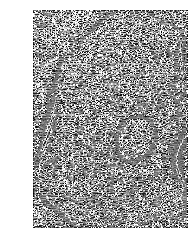

In [5]:
lbp_uniform = skft.local_binary_pattern(img,8,1,'uniform')

plt.imshow(lbp_uniform,cmap=plt.cm.gray)
plt.axis('off') 

In [6]:
lbp.shape

(273, 194)

In [7]:
max_bins = int(lbp.max()+1)

In [8]:
max_bins

256

In [8]:
data,_ = np.histogram(lbp,range(0,max_bins))

In [9]:
data.shape

(255,)

In [10]:
sum(data)

52962

In [11]:
lbp.shape

(273, 194)

In [12]:
273*194

52962

In [13]:
data.max()

6689

In [18]:
data

array([2125, 1971,   47,  486,  335,  133,  211,  950,   45,   32,    2,
          4,  174,   98,  279,  966, 2158,  814,   41,  145,  173,   17,
        148,  181,  534,  134,   12,   38, 1103,  175, 1155, 1214,   42,
         37,    1,    8,    7,    1,    6,   13,    2,    4,    0,    0,
         16,    4,   11,   31,  505,  125,   11,   30,   38,    2,   32,
         29,  530,   66,    6,   18, 1062,   48,  733,  400,  338,  191,
          7,   30,  113,   19,   38,   70,   10,    4,    0,    0,   37,
          8,   57,   54,  123,   28,    1,    6,   20,    1,    8,    8,
         33,    4,    1,    1,   67,    9,   64,   30,  236,  139,    3,
         31,   41,   15,   21,   63,    9,    6,    1,    0,   49,   20,
         54,   73, 1091,  184,   18,   34,   81,    5,   44,   39,  722,
         61,    7,   10, 1222,   59, 1014,  376,   51,  385,    2,  386,
          7,   22,    5,  604,    0,    8,    0,    1,    8,   19,   16,
        556,   33,  131,    1,   43,    6,    4,   

In [19]:
data/data.max()

array([3.17685753e-01, 2.94662879e-01, 7.02646135e-03, 7.26566004e-02,
       5.00822245e-02, 1.98833906e-02, 3.15443265e-02, 1.42024219e-01,
       6.72746300e-03, 4.78397369e-03, 2.98998356e-04, 5.97996711e-04,
       2.60128569e-02, 1.46509194e-02, 4.17102706e-02, 1.44416206e-01,
       3.22619226e-01, 1.21692331e-01, 6.12946629e-03, 2.16773808e-02,
       2.58633578e-02, 2.54148602e-03, 2.21258783e-02, 2.70593512e-02,
       7.98325609e-02, 2.00328898e-02, 1.79399013e-03, 5.68096875e-03,
       1.64897593e-01, 2.61623561e-02, 1.72671550e-01, 1.81492002e-01,
       6.27896547e-03, 5.53146958e-03, 1.49499178e-04, 1.19599342e-03,
       1.04649424e-03, 1.49499178e-04, 8.96995067e-04, 1.94348931e-03,
       2.98998356e-04, 5.97996711e-04, 0.00000000e+00, 0.00000000e+00,
       2.39198684e-03, 5.97996711e-04, 1.64449096e-03, 4.63447451e-03,
       7.54970848e-02, 1.86873972e-02, 1.64449096e-03, 4.48497533e-03,
       5.68096875e-03, 2.98998356e-04, 4.78397369e-03, 4.33547615e-03,
      

(array([116.,  45.,  19.,   5.,   4.,   7.,   4.,   5.,   1.,   1.,   1.,
          1.,   2.,   1.,   3.,   2.,   1.,   0.,   4.,   1.,   2.,   1.,
          0.,   1.,   2.,   0.,   0.,   1.,   2.,   1.,   0.,   1.,   0.,
          0.,   1.,   1.,   2.,   2.,   1.,   0.,   1.,   1.,   2.,   1.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

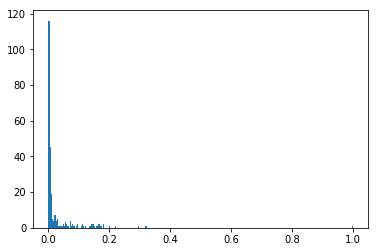

In [28]:
plt.hist(data/data.max(),bins=256)

In [17]:
filename1 = 'C:/Users/36451/Desktop/lubiao1.png'
img1 = cv2.imread(filename1,0)

(-0.5, 1238.5, 948.5, -0.5)

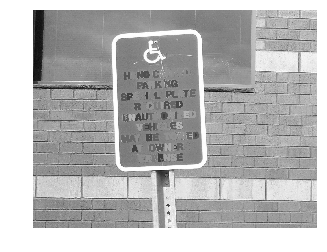

In [18]:
plt.imshow(img1,cmap=plt.cm.gray)
plt.axis('off')

In [20]:
lbp1=skft.local_binary_pattern(img1,8,1)

In [22]:
lbp1.shape

(949, 1239)

(-0.5, 1238.5, 948.5, -0.5)

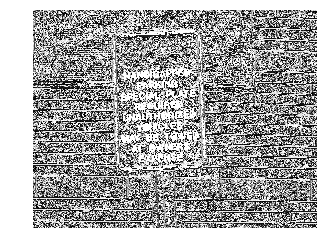

In [23]:
plt.imshow(lbp1,cmap=plt.cm.gray)
plt.axis('off')

In [24]:
max_bins = int(lbp.max() + 1)
max_bins

256

In [28]:
hist,_ = np.histogram(lbp1,range=(0,max_bins),bins=max_bins)

In [29]:
hist.shape

(256,)

(array([126.,  47.,  14.,  12.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          7.,   0.,   4.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   4.,
          2.,   1.,   3.,   1.,   2.,   3.,   1.,   1.,   1.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   3.,   1.,   0.,
          0.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

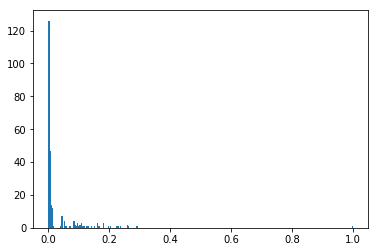

In [32]:
plt.hist(hist/hist.max(),bins=256)

In [1]:
def eightBitLMove(x,n=1):
    '''二进制是8位的操作'''
    number = x << n
    if number < 256:
        return number
    else:
        spillOver = 0
        missingPart = 0
        for i in range(0,n):
            spillOver = spillOver + 2**(i+8)
            missingPart = missingPart + 2**i
        totalSpillOver = spillOver - missingPart
        number = number - totalSpillOver
        return number

In [2]:
x = 220

In [4]:
eightBitLMove(x)

185

In [5]:
x

220

In [33]:
a = np.array([1,2,3,4])
b = np.array([[5,6,7,8],[2,3,4,5]])

In [31]:
c = np.append(a,b)

In [32]:
c

array([1, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5])

In [35]:
d = np.vstack((a,b))

In [36]:
d

array([[1, 2, 3, 4],
       [5, 6, 7, 8],
       [2, 3, 4, 5]])

In [46]:
x = np.array([])

In [47]:
type(x)

numpy.ndarray

In [49]:
y = np.append(x,1)

In [51]:
y.shape

(1,)

In [52]:
type(x)

numpy.ndarray

In [53]:
x.shape

(0,)